# PROJECT FOR GLOBAL AND MULTIOBJECTIVE OPTIMIZATION

## Imports and hyperparameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator
import math
import random

from copy import copy

import sys
import gc

import optuna
import logging
import pickle
from collections.abc import Callable
from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from pso_utils import *
from landscapes_utils import *
from gp_utils import *

In [2]:
# hyperparameters

SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100

__standard_result_flag = False
__original_hyperparameter_optimization_flag = False
__gp_run_check = False # when true we can perform the run

## Landscapes

The Landscapes class deals with fitness function used for PSO. It provides methods to translate (change minimum) and rotate the function. The considered functions are the following

In [3]:
for name in landscapes_names:
    print(name)

circle
rastrigin
schaffer
rosenbrock
easom
griewank


Let's plot the functions

In [4]:
# plotting utils
lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()

All the landscapes function have one global minimum in (0, 0). They can have multiple (or none) local minima.

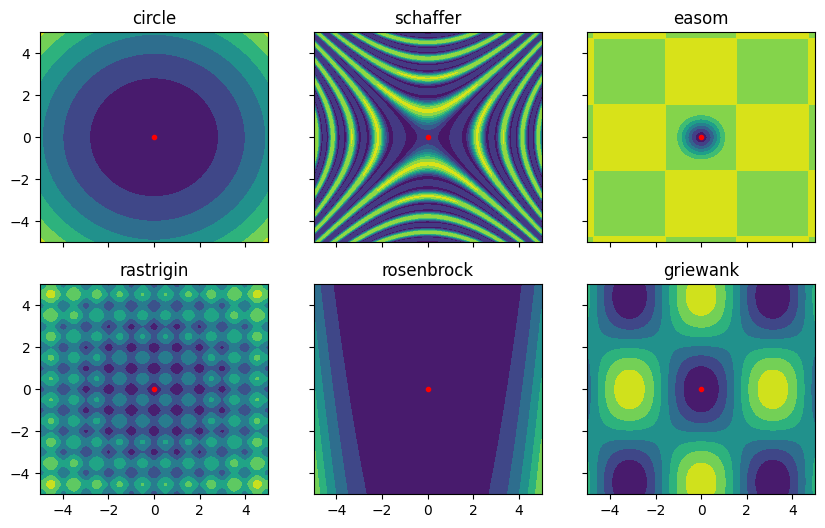

In [5]:
# plot standard landscapes

fig1, axs1 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    # landscape.rotation = rotation
    fit = landscape(pts)
    ax = axs1[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    ax.set_title(landscape.name)

To improve the generalization of PSO and GP we can translate and rotate the landscapes.

Rotation of 45°
New minimum = (1, -2)


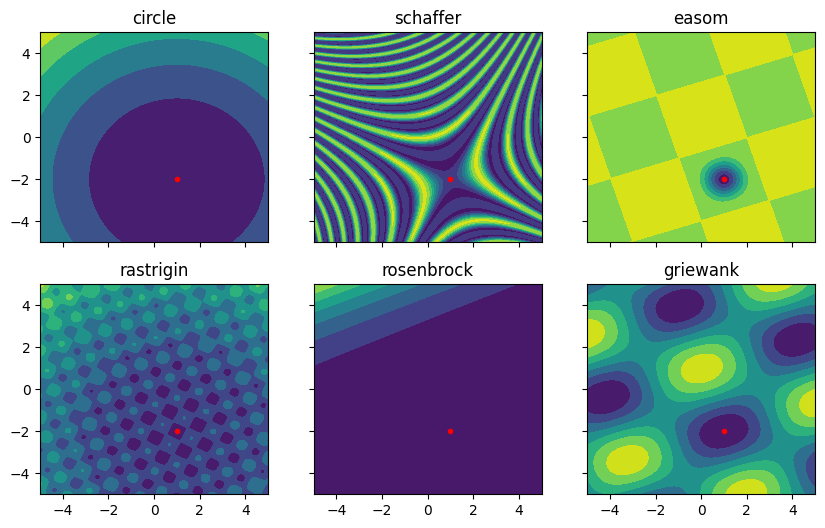

In [6]:
# plot rotated/translated landscapes

angle = 0.4 # pi/4
rotation = generate_rotation_matrix(angle*np.pi)
minimum = np.array([[1, -2]])
print(f'Rotation of 45°')
print(f'New minimum = ({minimum[0, 0]}, {minimum[0, 1]})')

fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    landscape.rotation = rotation
    landscape.minimum = minimum
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    # ax.arrow(0, 0, landscape.minimum[0, 0], landscape.minimum[0, 1], color='red')
    ax.set_title(landscape.name)

## PSO class

### Intro

Example of PSO execution. The star is the function optimum, the green cross is the best position found by the swarm and the red square is the center of mass of the swarm

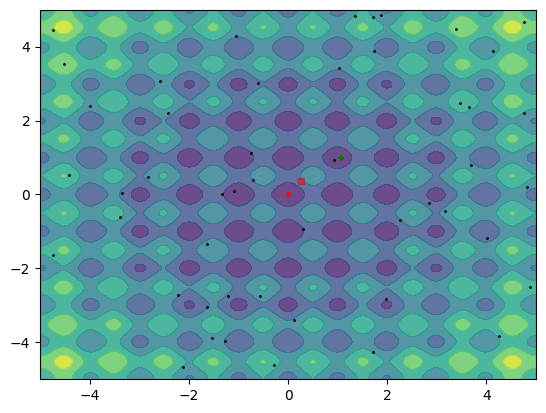

In [7]:
S = SwarmGP(50)
S.default_start(land=copy(RASTRIGIN))
fit = S.land(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9)
S.plot()

In [8]:
S.generate(200)
S.describe()

best fit value = 0.00018924744426129791
best solution = [-0.0002456 -0.0009453]
center of mass = [0.50089047 0.04210443]
dispersion = 1.360980177366157


(-5.0, 5.0)

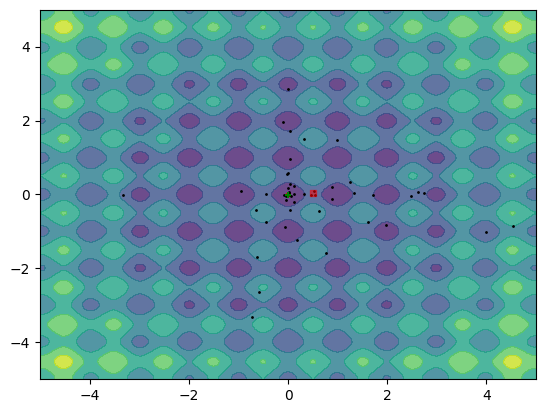

In [9]:
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9)
S.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

### Hyperparameter optimization of original velocity formula

We calculate the performance obtained with the original parameters is 4.6689

In [10]:
if __standard_result_flag:
    standard_swarm = SwarmGP(SWARM_SIZE)

    standard_results = PSOResults(standard_swarm, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)

    standard_value = float(np.median(standard_results) + np.std(standard_results))
    standard_value

We try to optimize the social factor, cognitive factor and inertia weight of the original velocity update.

In [11]:
def original_update_dec(soc_factor, cog_factor, inertia_weight):
    """Decorator used to fix some parameters of the original velocity update"""

    def new_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion):
        return original_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion, soc_factor=soc_factor, cog_factor=cog_factor, inertia_weight=inertia_weight)
    return new_update

In [12]:
def GPObjectiveBase(trial):
    """Objective function for the hyperparameter optimization"""
    
    soc_factor = trial.suggest_float('soc_factor', 0, 5)
    cog_factor = trial.suggest_float('cog_factor', 0, 5)
    inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
    vel_update = original_update_dec(soc_factor, cog_factor, inertia_weight)


    results = PSOResults(swarm, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)

    return float(np.median(results) + np.std(results))

In [13]:
study_name = "optimization_folder/modular_version1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)

if __original_hyperparameter_optimization_flag:
    study.optimize(GPObjectiveBase, n_trials=200, )

[I 2024-12-17 09:34:53,058] Using an existing study with name 'optimization_folder/modular_version1' instead of creating a new one.


The best parameters obtained are:

In [14]:
print(f'best parameters -> {study.best_params}')
print(f'best value -> {study.best_value}')

best parameters -> {'soc_factor': 0.37098323712381176, 'cog_factor': 2.4430009951118525, 'inertia_weight': 0.15780578019083405}
best value -> 2.216855343261271


<!-- ## Genetic programming -->

# GP

### Training

We train models having mutation type **subtree mutation** or **shrink mutation**. There are two version implementing a stochastic factor (a function that generates a matrix of random numbers each time it is called).

In [15]:
def safe_dec(func):
    """Ensures that the output of an individual is a numpy array of dimension (SWARM_SIZE, 2)"""
    
    def new_func(swarm, velocity, global_best, personal_best, center_mass, dispersion):
        value = func(swarm, velocity, global_best, personal_best, center_mass, dispersion)
        if not isinstance(value, np.ndarray):
            return np.zeros((SWARM_SIZE, 2))
        else:
            try:
                value.shape[1] == 2
                return value
            except Exception:
                value = value.reshape(-1, 1)
                value = np.hstack((value, value))
                return value
    return new_func

In [16]:
def gen_rand(_):
    return np.random.uniform(np.zeros(2), np.ones(2), size=(SWARM_SIZE, 2))

In [17]:
def GP_RUN(name=None, mut_type='uni'):
    pset = gp.PrimitiveSet("MAIN", 6)
    # basic
    pset.addPrimitive(np.add, 2)
    pset.addPrimitive(np.negative, 1)
    pset.addPrimitive(np.subtract, 2)
    pset.addPrimitive(np.multiply, 2)
    # pset.addPrimitive(gen_rand, 1) # manually inserted

    # PRIMITIVES
    pset.addTerminal(np.pi)
    pset.addTerminal(1)
    # ephemeral constants
    pset.addEphemeralConstant("rand101", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand102", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand103", partial(random.uniform, 0, 5))

    # variables
    pset.renameArguments(ARG0="swarm")
    pset.renameArguments(ARG1="vel")
    pset.renameArguments(ARG2='gbest')
    pset.renameArguments(ARG3='pbest')
    pset.renameArguments(ARG4='center')
    pset.renameArguments(ARG5='dispersion')

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5) # 3<5
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    def GPFitness(individual):
        """Fitness of a gp individual"""
        
        problems = generate_problems(NUM_PROBLEMS)
        func = toolbox.compile(expr=individual)
        func = safe_dec(func)
        vel_update = func
        S = SwarmGP(SWARM_SIZE, vel_update=vel_update)
        results = PSOResults(S, problems, NUM_ITERATIONS)
        value = float(np.median(results) + np.std(results))
        print(f'value = {value} -> ind = {individual}')
        return value,


    toolbox.register("evaluate", GPFitness)
    toolbox.register("select", tools.selTournament, tournsize=3) # 1:1 replacement selection
    toolbox.register("mate", gp.cxOnePoint) # subtree crossover

    # mutations

    if mut_type == 'uni':
        toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
        toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    elif mut_type == 'shrink':
        toolbox.register("mutate", gp.mutShrink)
    
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))

    def gp_run():
        random.seed(318)

        pop = toolbox.population(n=50)
        hof = tools.HallOfFame(5)

        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        stats_height = tools.Statistics(lambda ind: ind.height)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size, height=stats_height)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.2, ngen=20, stats=mstats,
                                    halloffame=hof, verbose=False)
        # doesn't recompute individuals that do not change
        if name is not None:
            save_hof(hof, f'logs/hof_{name}.pkl')
            save_pop(pop, f'logs/pop_{name}.pkl')
            save_log(log, f'logs/log_{name}.pkl')
            
        return pop, log, hof
    return gp_run()

In [18]:
if __gp_run_check:
    pop, log, hof = GP_RUN(name='uni_norand')

### Plotting results

In [19]:
log_uni_r = load_log()
log_uni = load_log('logs/log_uni_norand.pkl')
log_sh_r = load_log('logs/log_shrink.pkl')
log_sh_3r = load_log('logs/log_shrink_mut03.pkl')
log_sh_5r = load_log('logs/log_shrink_mut05.pkl')
log_sh_3 = load_log('logs/log_shrink_mut03_norand.pkl')
log_sh_5 = load_log('logs/log_shrink_mut05_norand.pkl')

Uniform mutation results.

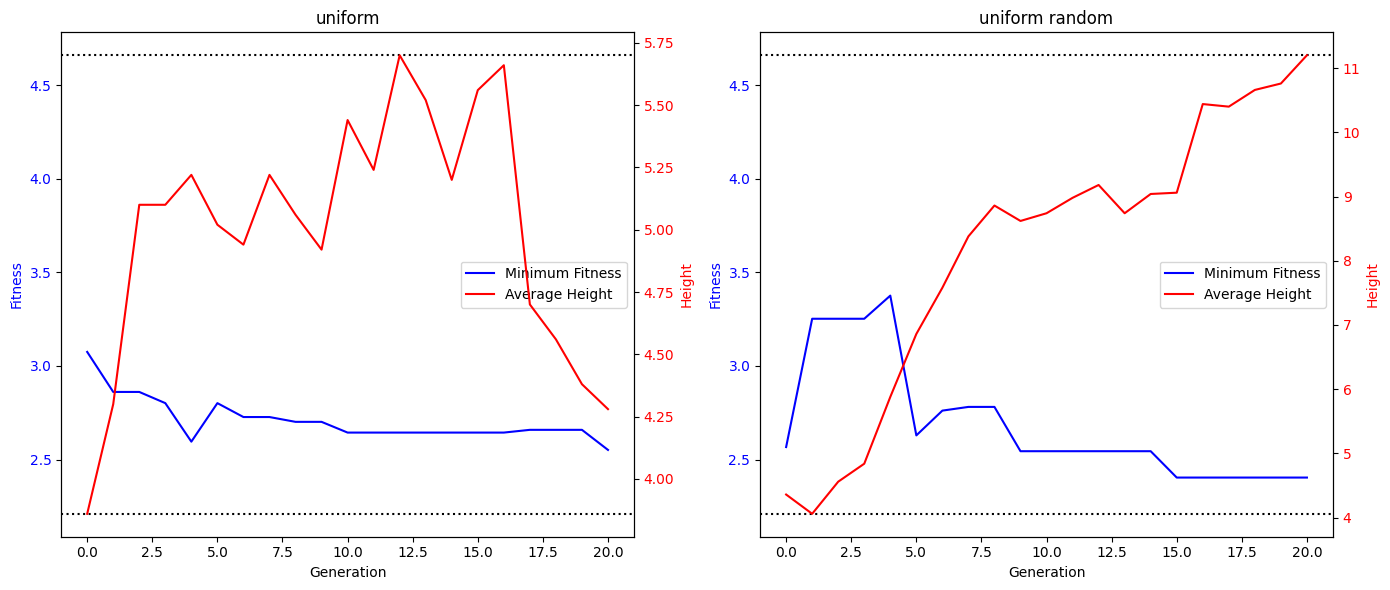

In [20]:
# uniform comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_log(log_uni, ax1=axs[0])
axs[0].set_title("uniform")

plot_log(log_uni_r, ax1=axs[1])
axs[1].set_title("uniform random")

plt.tight_layout()

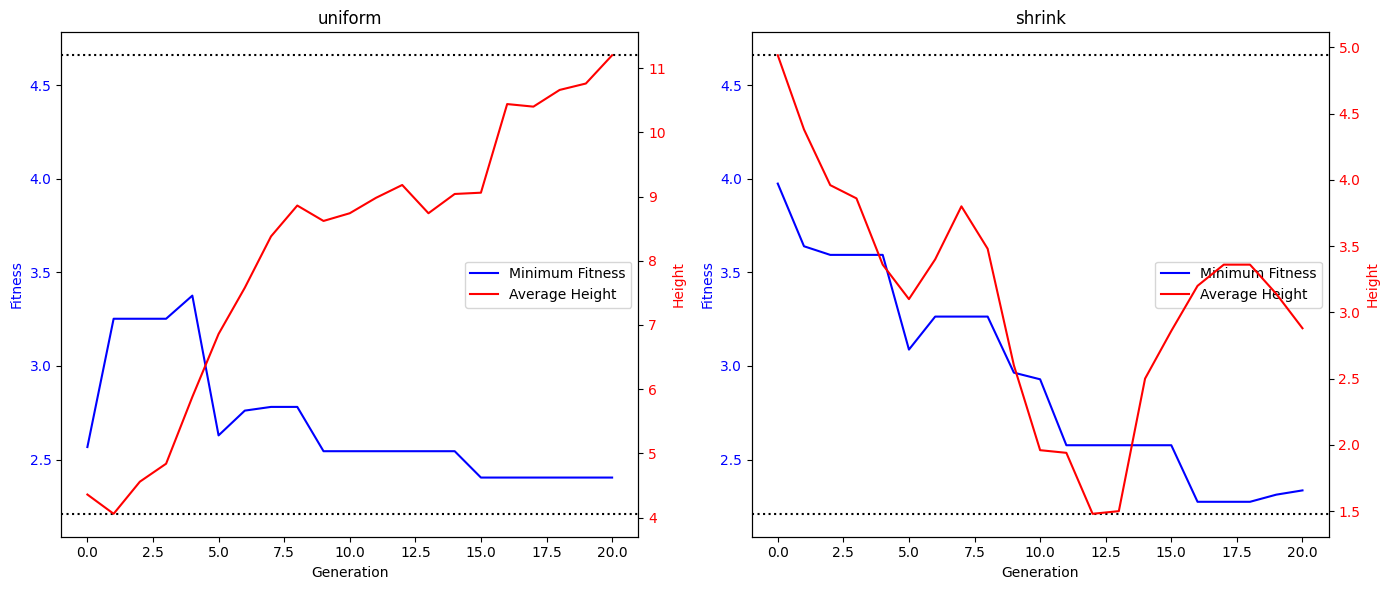

In [21]:
# comparison uniform and shrink
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_log(log_uni_r, ax1=axs[0])
axs[0].set_title("uniform")


plot_log(log_sh_r, ax1=axs[1])
axs[1].set_title('shrink')

plt.tight_layout()

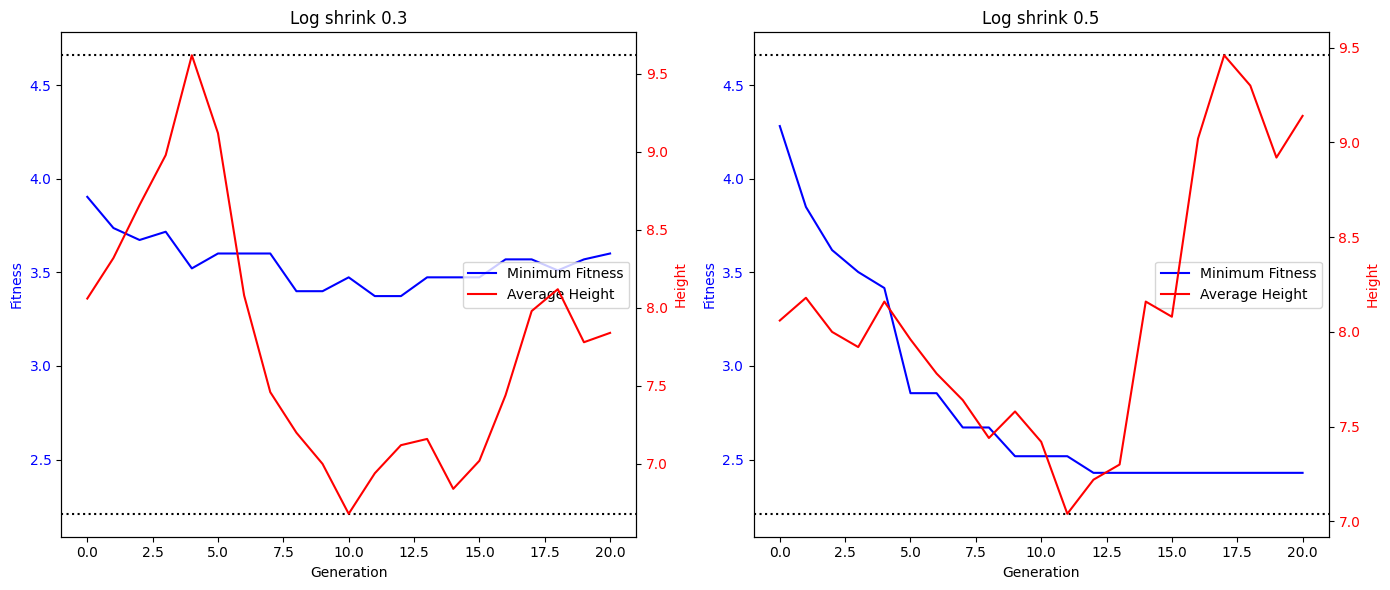

In [22]:
# comparison non random shrink
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


plot_log(log_sh_3, ax1=axs[0])
axs[0].set_title("Log shrink 0.3")


plot_log(log_sh_5, ax1=axs[1])
axs[1].set_title("Log shrink 0.5")


plt.tight_layout()

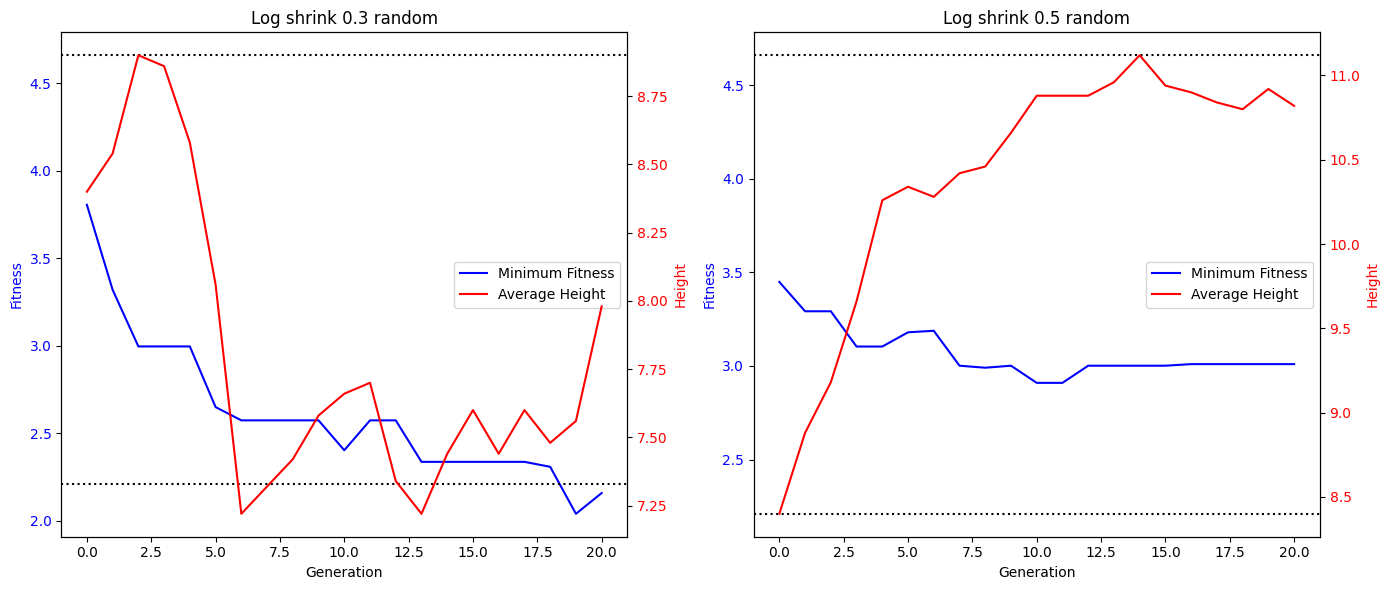

In [23]:
# random shrink
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_log(log_sh_3r, ax1=axs[0])
axs[0].set_title("Log shrink 0.3 random")


plot_log(log_sh_5r, ax1=axs[1])
axs[1].set_title("Log shrink 0.5 random")


plt.tight_layout()

### Hall of fame

In [24]:
hof_uni_r = [clean_rand(str(ind)) for ind in load_hof()]
hof_uni = [clean_rand(str(ind)) for ind in load_hof('logs/hof_uni_norand.pkl')]
hof_sh_r = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink.pkl')]
hof_sh_3r = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut03.pkl')]
hof_sh_5r = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut05.pkl')]
hof_sh_3 = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut03_norand.pkl')]
hof_sh_5 = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut05_norand.pkl')]

In [25]:
[clean_rand(str(ind)) for ind in hof_uni], [clean_rand(str(ind)) for ind in hof_uni_r]

(['negative(add(swarm, vel))',
  'add(add(add(add(subtract(center, center), add(dispersion, vel)), multiply(subtract(1, swarm), add(3.141592653589793, gbest))), negative(subtract(multiply(swarm, 3.141592653589793), negative(dispersion)))), negative(add(negative(subtract(3.141592653589793, 1.0897868079565776)), negative(multiply(multiply(0.4500763667229857, swarm), subtract(1, 0.09513263173459185))))))',
  'multiply(subtract(add(dispersion, 1), multiply(negative(negative(subtract(multiply(negative(vel), negative(add(swarm, dispersion))), add(negative(4.148730254414338), negative(dispersion))))), dispersion)), add(add(center, 1.547079513370106), add(add(swarm, vel), center)))',
  'negative(add(swarm, add(swarm, dispersion)))',
  'negative(add(vel, add(center, swarm)))'],
 ['subtract(multiply(add(add(negative(multiply(add(dispersion, swarm), gen_rand(0))), subtract(add(negative(0.33109915628712405), negative(pbest)), add(multiply(1, pbest), negative(0.6574626132130562)))), add(add(add(add

In [26]:
[clean_rand(str(ind)) for ind in hof_sh_r] #useless

['negative(multiply(swarm, subtract(3.141592653589793, 1)))',
 'negative(multiply(swarm, add(3.141592653589793, negative(1.5222510478769187))))',
 'negative(multiply(swarm, add(subtract(3.141592653589793, 1), 1.5222510478769187)))',
 'negative(multiply(swarm, add(3.223048609228983, negative(1.5222510478769187))))',
 'negative(multiply(swarm, add(subtract(3.141592653589793, 1), negative(1.5222510478769187))))']

In [27]:
[clean_rand(str(ind)) for ind in hof_sh_3], [clean_rand(str(ind)) for ind in hof_sh_3r] # the second is useless

(['multiply(multiply(negative(subtract(negative(multiply(vel, 1.3826780595714894)), multiply(subtract(pbest, swarm), negative(1)))), add(negative(subtract(2.1850929323756763, multiply(3.7181358637881012, 1.0739336705256557))), subtract(add(add(0.552265030891726, 1.8377044553995874), subtract(gbest, dispersion)), negative(subtract(2.5055440274728067, swarm))))), add(add(subtract(subtract(swarm, swarm), multiply(negative(1), center)), negative(subtract(center, 3.305688576964356))), negative(subtract(subtract(pbest, gbest), negative(center)))))',
  'multiply(multiply(negative(subtract(negative(multiply(vel, 1.3826780595714894)), multiply(subtract(pbest, swarm), negative(1)))), add(negative(subtract(subtract(gbest, dispersion), multiply(3.7181358637881012, 1.0739336705256557))), subtract(add(add(multiply(1, dispersion), 1.8377044553995874), add(center, pbest)), negative(subtract(2.5055440274728067, add(negative(subtract(subtract(gbest, dispersion), multiply(3.7181358637881012, 1.0739336705

In [28]:
[clean_rand(str(ind)) for ind in hof_sh_5], [clean_rand(str(ind)) for ind in hof_sh_5r] # useless

(['negative(negative(subtract(negative(add(add(center, add(dispersion, swarm)), subtract(add(add(gbest, add(add(subtract(swarm, swarm), swarm), negative(4.5640609907865315))), swarm), gbest))), negative(subtract(multiply(1, dispersion), add(swarm, 3.028784002249096))))))',
  'negative(negative(negative(add(add(1, add(add(swarm, swarm), swarm)), swarm))))',
  'negative(negative(negative(add(add(1, add(add(subtract(swarm, swarm), swarm), swarm)), swarm))))',
  'negative(negative(subtract(negative(swarm), negative(subtract(multiply(1, dispersion), add(swarm, 3.028784002249096))))))',
  'negative(negative(negative(add(add(add(1, swarm), swarm), swarm))))'],
 ['multiply(multiply(negative(subtract(gen_rand(0), gen_rand(0))), gen_rand(0)), gen_rand(0))',
  'multiply(multiply(negative(subtract(gen_rand(0), gen_rand(0))), gen_rand(0)), gen_rand(0))',
  'multiply(multiply(negative(subtract(gen_rand(0), gen_rand(0))), gen_rand(0)), gen_rand(0))',
  'multiply(multiply(negative(subtract(gen_rand(0)

### Best result

The best balance between performance and interpretability was achieved by:
$$vel -swarm * 3.141592653589793 - dispersion + center$$
$$- (center + 2*swarm + global_best + 1.7 - velocity)$$
We will also compare to another less performan result:
$$(3.14 - dispersion * velocity * (swarm + dispersion)) * (2*center_mass + swarm + velocity + 1.5)$$

In [98]:
def update1(swarm, velocity, global_best, personal_best, center_mass, dispersion):

    n = 50
    # update velocity
    velocity = velocity + (center_mass - 3.14*swarm) - dispersion
    return velocity

In [30]:
mean_result1 = 0
for i in range(20):
    
    S = SwarmGP(SWARM_SIZE, update1)
    results = PSOResults(S, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)
    mean_result1 += (np.median(results) + np.std(results))/20
mean_result1

4.334890478621283

In [99]:
def update2(swarm, velocity, global_best, personal_best, center_mass, dispersion, inertia_weightc=1, disp_factor=1, c=3.14):

    n = 50
    # update velocity
    velocity = -(center_mass + 2*swarm + global_best - velocity + 1.7)
    # velocity = (3.14 - dispersion * velocity * (swarm + dispersion)) * (2*center_mass + swarm + velocity + 1.5)
    return velocity

In [92]:
mean_result2 = 0
for i in range(20):
    
    S = SwarmGP(SWARM_SIZE, update2)
    results = PSOResults(S, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)
    mean_result2 += (np.median(results) + np.std(results))/20
mean_result2

4.4855384406342225

In [100]:
def update3(swarm, velocity, global_best, personal_best, center_mass, dispersion, inertia_weightc=1, disp_factor=1, c=3.14):

    n = 50
    # update velocity
    velocity = (3.14 - dispersion * velocity * (swarm + dispersion)) * (2*center_mass + swarm + velocity + 1.5)
    return velocity

In [93]:
mean_result3 = 0
for i in range(20):
    
    S = SwarmGP(SWARM_SIZE, update2)
    results = PSOResults(S, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)
    mean_result3 += (np.median(results) + np.std(results))/20
mean_result3

4.400817151969945

The two functions improve on the deault implementation of the standard velocity update (the one with social and cognitive factor equal to 1.49 and inertia decay equal to 0.9). We plot them to check their behaviou on different problems.

In [104]:
FINAL_PROBLEMS = basic_landscapes
for land in FINAL_PROBLEMS:
    new_minimum = np.random.uniform(-2, 2, size=(1, 2))
    angles = np.random.uniform(0, 2)
    land.minimum = new_minimum
    land.rotation = generate_rotation_matrix(angle*np.pi)

First we check the first update function

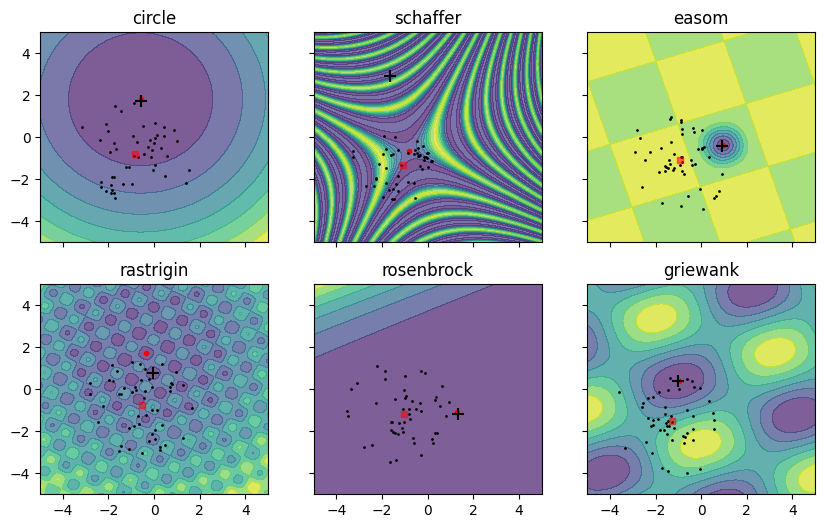

In [107]:
fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = FINAL_PROBLEMS[i]

    S = copy(SwarmGP(SWARM_SIZE, vel_update=update1))
    S.default_start(land=landscape)
    S.generate(100)
    
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.7)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)

    # plot swarm
    ax.scatter(S.swarm[:, 0], S.swarm[:, 1], s=1, color='black')
    ax.scatter(S.center_mass[:, 0], S.center_mass[:, 1], s=16, color='red', marker='s', alpha=0.5)
    ax.scatter(S.global_best[:, 0], S.global_best[:, 1], s=81, color='black', marker='+')

    ax.set_title(landscape.name)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

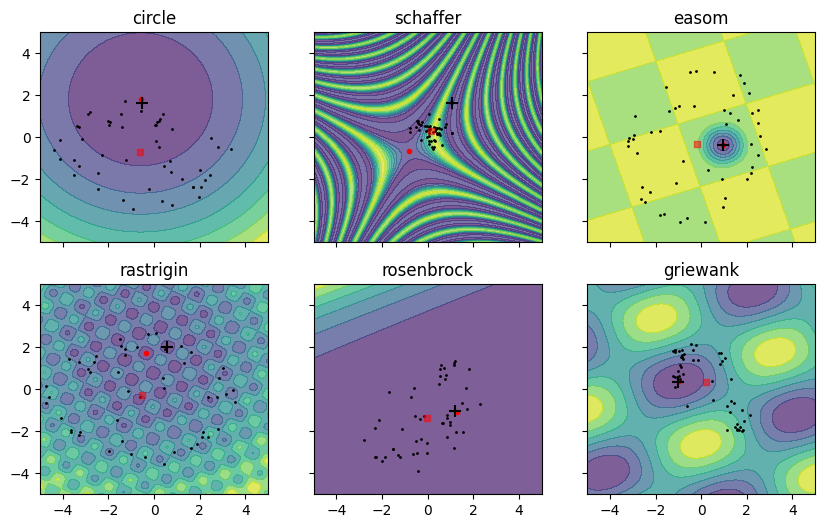

In [106]:
fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = FINAL_PROBLEMS[i]

    S = SwarmGP(SWARM_SIZE, vel_update=update2)
    S.default_start(land=landscape)
    S.generate(100)

    
    
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.7)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)

    # plot swarm
    ax.scatter(S.swarm[:, 0], S.swarm[:, 1], s=1, color='black')
    ax.scatter(S.center_mass[:, 0], S.center_mass[:, 1], s=16, color='red', marker='s', alpha=0.5)
    ax.scatter(S.global_best[:, 0], S.global_best[:, 1], s=81, color='black', marker='+')

    ax.set_title(landscape.name)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

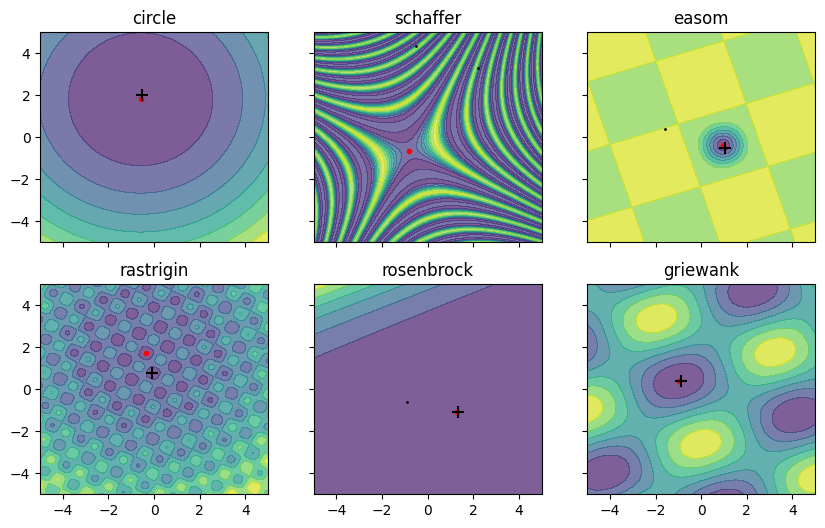

In [108]:
fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = FINAL_PROBLEMS[i]

    S = SwarmGP(SWARM_SIZE, vel_update=update3)
    S.default_start(land=landscape)
    S.generate(100)

    
    
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.7)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)

    # plot swarm
    ax.scatter(S.swarm[:, 0], S.swarm[:, 1], s=1, color='black')
    ax.scatter(S.center_mass[:, 0], S.center_mass[:, 1], s=16, color='red', marker='s', alpha=0.5)
    ax.scatter(S.global_best[:, 0], S.global_best[:, 1], s=81, color='black', marker='+')

    ax.set_title(landscape.name)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)